# Raster Fundamentals

February 22, 2019  
David Shean

## Objectives
* Learn how to inspect, read and write raster data
* Manipulate raster data as NumPy arrays, do basic band math
* Explore Landsat-8 archive

## Tools
* GDAL
* Rasterio
* NumPy

# Introduction

## What is a raster?

## Raster data sources
* Satellite imagery
* Gridded model output
* Interpolated vector data

# Raster fundamentals (interactive discussion)

### Dimensions (width [columns] and height [rows] in pixels)
### CRS (coordinate system)
### Extent (bounds)
### Resolution (pixel size)
### Data type (bit depth)
### Number of bands
### NoData values
### Overviews

## Raster transformations
* Need a way to go from pixel coordinates to real-world coordinates
    * Pixel coordinates: image width, height in units of pixels, starting at (0,0)
    * Real-world coordiantes: projected coordinate system (e.g., UTM 10N), units of meters
* Origin is usually upper left corner of upper left pixel
    * Careful about this - you will definitely run into this problem at some point
    * Often your grid may be shifted by a half a pixel in x and y

### GDAL/ESRI affine

### rasterio affine

## GDAL (Geospatial Data Abstraction Library) and Rasterio
GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. One such python library developed and supported by Mapbox, rasterio, builds on top of GDAL’s many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved.

## Raster formats
* GeoTiff is most common
* GDAL is the foundation

## Projections
* Most often UTM
* PROJ is the foundation

## GDAL command line utilities

* Learn these: https://www.gdal.org/gdal_utilities.html
    * gdalinfo
    * gdal_translate
    * gdalwarp
    * gdaladdo
* Items to discuss
    * Use standard creation options (co)
        * TILED=YES
        * COMPRESS=LZW
        * BIGTIFF=IF_SAFER
    * Resampling algorithms
        * Default is nearest
        * Often bilinear or bicubic is a better choice for reprojecting, upsampling, downsampling

https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971

# Landsat-8 Example
* Hopefully you've all seen or used Landsat imagery in the past
* Take a few minutes to refresh your memory: https://www.usgs.gov/land-resources/nli/landsat
* There is a huge amount of information out there on the Landsat missions, data products, science results
* Let's explore a single raster dataset from Landsat-8 (LS8) to start

## Bands
* https://landsat.usgs.gov/what-are-band-designations-landsat-satellites

![LS8 band table](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/Landsat%208%20band%20designations.jpg)

So, the top row in the following figure:

![LS8 bands](https://landsat.usgs.gov/sites/default/files/images/MSS-thru-L9-wavelengths.jpg)

## Notes

These are "Level 1" images: they radiometrically calibrated and orthorectified (terrain corrected) in UTM projection: https://landsat.usgs.gov/landsat-level-1-standard-data-products

For more sophisticated analysis, you typically want to use higher-level, calibrated/corrected products ("level 2" like surface reflectance values): https://www.usgs.gov/land-resources/nli/landsat/landsat-science-products

### Dynamic Range
* LS8 OLI provides 12-bit dynamic range: https://landsat.usgs.gov/how-does-landsat-8s-12-bit-data-improve-data-products
    * Remember, each bit is a 0 or 1.  We have 12 of them, so we have 2^12 (or 4096) unique combinations to represent brightness in the image.
* Most data types on a computer are in multiples of 8-bit bytes.  For example, a typical image of a cat face contains three 8-bit channels for red, green and blue values
* We don't have a convenient mechanism to store 12-bit data, so the LS8 images are stored as 16-bit unsigned integers (2^16 possible values, 0-65535)

### Resolution or Ground Sample Distance (GSD)
* PAN band (8) is 15 m ground sample distance (GSD)
* Multispectral (MS) bands are 30 m
* Thermal IR are 100 m

* LS imagery is already orthorectified
    * Original "Level 0" or "Level 1A" imagery in sensor coordinates is not available
    * Most people want orthoimages
    * Can be distortion if the DEM used for orthorectification contains errors (or the surface has changed between the DEM timestamp and image timestamp)

### Revisit interval of 16 days

### Path/Row system
* https://landsat.usgs.gov/what-worldwide-reference-system-wrs (you want descending for daytime imagery)
* Seattle and Mt. Rainier: path 46, row 27

### LS8 Data availability

The USGS hosts the official Landsat products.  Both Google and Amazon mirror the entire USGS archive.

Google:
* https://cloud.google.com/storage/docs/public-datasets/landsat

Amazon Web Services (AWS): 
* https://docs.opendata.aws/landsat-pds/readme.html
* https://registry.opendata.aws/landsat-8/

In [1]:
import os
import urllib

In [2]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

import matplotlib.pyplot as plt
import numpy as np

#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#https://pypi.org/project/matplotlib-scalebar/
#ax.add_artist(Scalebar(res)) where res is the pixel resolution in meters
#If already set imshow(extent=extent) parameter, use res=1.0

In [3]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
#doing matplotlib inline for HW submission!!
%matplotlib inline

## Finding cloud-free imagery
* Can use EarthExplorer for visual queries: https://earthexplorer.usgs.gov/
    * Get the image ID
    * Can also directly download products from EarthExplorer, but pretty inefficient
* There are automated ways to query the archives from Python or command-line, but for now, let's just use pre-identified images or manually identified IDs

In [4]:
#img_id = 'LC08_L1TP_042034_20170616_20170629_01_T1'
#image_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B3.TIF'

## We could do all of this on the fly from URLs, but let's download this example locally for our analysis
* Note that transfer rates from Google Cloud should be excellent, as we're running this Jupyterhub on a Google Cloud Platform (GCP) server
* Notes about LS filenames: https://gisgeography.com/landsat-file-naming-convention/

In [5]:
#Use Google Cloud archive
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

#Define path/row of interest
path = 46
row = 27

#Pre-identified cloud-free Image IDs
img_id1 = 'LC08_L1TP_046027_20181224_20190129_01_T1'
img_id2 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
img = img_id2

In [6]:
#Create local directory to store images
imgdir = 'LS8_sample'
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

#Loop through all bands and download images
for b in range(1,12):
    image_url =  '{0}/{1:03d}/{2:03d}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, b)
    print(image_url)
    #Local filename
    out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
    
    if not os.path.exists(out_fn):
        print("Saving:", out_fn)
        urllib.request.urlretrieve(image_url, out_fn)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
Saving: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B1.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B2.TIF
Saving: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B2.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B3.TIF
Saving: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B3.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B4.TIF
Saving: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B4.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_2018

## Do a quick `ls -lh` on the local image directory
* Note relative file sizes for the different bands
    * B8 vs B3 vs. B10
    * Revisit the chart above - does this make sense for resolution of these bands?

### B8: 265M - 15m resolution
### B3: 69M - 30m resolution
### B10: 50M - 100m resolution
## These data sizes are logical and seem to follow the resolution size

## Use `gdalinfo` to get some basic information about one of the files
* Review each line of the output with your neighbor
    * Talk about what each line means, if there is something you don't understand, ask!

In [7]:
#Specify filenames for different bands
#Sample for red band filename
r_fn = os.path.join(imgdir, img+'_B4.TIF')
#Repeat for PAN, green, blue, near-IR1, SWIR
g_fn = os.path.join(imgdir, img+'_B3.TIF')
b_fn = os.path.join(imgdir, img+'_B2.TIF')
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
p_fn = os.path.join(imgdir, img+'_B8.TIF')

# GDAL Python API basics
* I'm including this for reference
    * It's not that complicated, even though rasterio is the more popular option these days (partly because of much better documentation)
* https://www.gdal.org/gdal_datamodel.html
* https://www.gdal.org/gdal_tutorial.html
* https://github.com/OSGeo/gdal/tree/master/gdal/swig/python/samples
* https://pcjericks.github.io/py-gdalogr-cookbook/index.html

In [8]:
#Open tif file as GDAL Dataset object
ds = gdal.Open(g_fn)

In [9]:
#Get the raster band
gdal_b = ds.GetRasterBand(1)
#Read into array
a = gdal_b.ReadAsArray()

In [10]:
#Inspect the array
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

# Rasterio basics
* We'll stick with rasterio for most of our Python raster analysis 
* https://rasterio.readthedocs.io/en/stable/quickstart.html

## Open an image directly from a url (look Ma, no downloads!)

In [11]:
print(image_url)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/027/LC08_L1TP_046027_20180818_20180829_01_T1/LC08_L1TP_046027_20180818_20180829_01_T1_B11.TIF


## Use a python `with` construct to cleanly open, inspect, and close the file directly from the url
* Print out the dataset profile

In [12]:
with rasterio.open(image_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_dict(init='epsg:32610'), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


## Open directly, for interactive use outside of the `with` statement
* Remember to close the rasterio dataset later

In [13]:
dSet = rasterio.open(image_url)
dSet = None
# just closed here so I would remember. Can comment out

## Open a single image from disk
* Since we already downloaded, let's open the red band (4) TIF
* We already defined the r_fn available above
* Inspect the profile output

In [14]:
rBnd = rasterio.open(r_fn)
rBnd.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_dict(init='epsg:32610'), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

## What is the CRS?
* Look familiar?  The underlying `fiona` functionality was written by the same author. Look up and add a note with the proj string for this projection

### EPSG:32610
### +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs 

## What is the raster extent (bounds) in projected coordinates?

In [15]:
rBnd.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

## How many bands are there in this tif file?

In [16]:
rBnd.count

1

## Review the full metadata record
* Use the rasterio `meta` attribute, which should return a dictionary

In [17]:
rBnd.meta

{'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7881,
 'nodata': None,
 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0),
 'width': 7781}

## Read the data into a NumPy array and preview
* What band number do you need to use here?
* What are the dimensions of your array?  Is this consistent with the rasterio width and height attributes?

(7881, 7781)


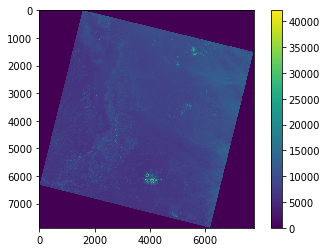

In [18]:
rBndNP = rBnd.read(1)
print(rBndNP.shape)
# need to use band number 1 (only band for this raster).
# The dimensions correspond to the height and width determined above

plt.figure()
plt.imshow(rBndNP)
plt.colorbar()

## What is the uncompressed filesize of this array?
* You'll need the datatype and dimensions
* This is how much RAM the image is occupying on your system
* How does this compare with the file size on disk?
    * If different, why might they be different?

In [19]:
# the datatype from above was listed as uint16 which formats numbers using a precision of 2 bytes (16 bits)
# From the dimensions determined above...
2*7881*7771/1000000

122.486502

#### Tiff file = 70MB
#### array = 122MB
#### The array is ~1.7 times the size of the raster. This is likely due to the fact that the raster size is reduced with LZW compression. LZW lossless compression is used for TIF and GIF files and uses a lookup table to help reduce redundancy. For example, repeated values or patterns of values are identified and replaced with a simplified lookup code. The array size may also be significantly larger oweing to the large amount of zero values off the edge of the scene that are unncessary in the tif file format.

## Create a plot of the image
* Start by using matplotlib `imshow`
* Use the `gray` color ramp
* Note that the image appears "rotated" relative to the frame
    * Why is this?
* Note the coordinate system (where is the origin), and the interactive coordinates and pixel DN values
    * Look at values over Mt. Rainier, Puget Sound, Outer "black" border

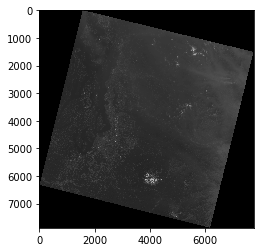

In [20]:
plt.figure()
plt.imshow(rBndNP,cmap='gray')

### With respect to Landsat's path, the image is not skewed. However, when exporting to 2D cartesian coordinates with Northing and Easting (UTM) axes, it is clear to see that the edge of the image is not oriented well with respect to the North-South (or East-West) frames in this coordinate system. This would be more obvious with the actual coordinates plotted on the axes. However, you can clearly see that the origin is the top-left corner, which is often typical for raster analysis.
### Some of largest digital numbers in the scene are being seen over Mt. Rainier with values over 33500. However, the DN's on the border are all at zero. This is therefore a large range and is washing out a lot of the contrast in the scene.

## Create a histogram plot of DN (dynamic number) values in your array
* Does `hist()` expect a 2D array or a 1D array? Take a look at the NumPy `ravel` function...
* Which bin has the highest count?
* Over what range do most of the DN values fall?

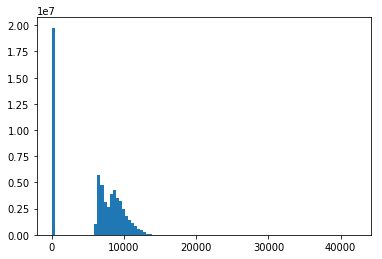

In [21]:
plt.figure()
bins = plt.hist(np.ravel(rBndNP),100)

In [22]:
# bin with highest count
# attempting to make reproducible even though you can clearly see this
print('bin with highest count: left side of bin = %4.2f' %(bins[1][np.argmax(bins[0])]))
print('bin with highest count: right side of bin = %4.2f' %(bins[1][np.argmax(bins[0])+1]))

# bins with non-zero counts beyond first peak (DNs of scene)
# considering only below upper 97 percentile for best contrast
# left bin edges
zeridxs = bins[1][np.where(bins[0] > 0)]
upperidxs = bins[1][np.where(bins[1] <= np.percentile(np.ravel(rBndNP),97))]
print('range of most DN values: %4.2f to %4.2f' %(zeridxs[1], upperidxs[-1]))

bin with highest count: left side of bin = 0.00
bin with highest count: right side of bin = 421.45
range of most DN values: 4635.95 to 11379.15


## Let's get rid of that black (DN values equal 0) border
* Try to use a numpy masked array to do this (should be a simple one-liner)
* https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
* Preview your new array, inspect the mask
* Try plotting with imshow and generating a new histogram

In [23]:
rBndNP_masked = np.ma.masked_equal(rBndNP,0)
rBndNP_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

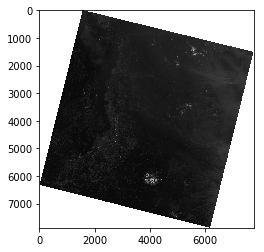

In [24]:
plt.figure()
plt.imshow(rBndNP_masked,cmap='gray')

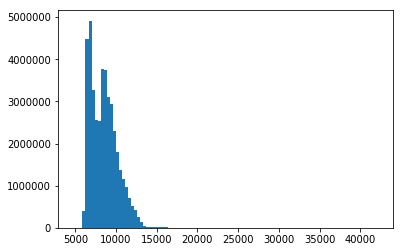

In [25]:
plt.figure()
bins = plt.hist(np.ravel(rBndNP_masked),100)

## Determine the pixel DN (dynamic number) representing the 2nd and 98th percentile

In [26]:
# I think the problem witht he 2nd percentile here is that we have a very lognormal distribution of values. 
#If we had a more normal distribution it would be able to filter the lowest 2%
print(np.percentile(rBndNP_masked,2,interpolation='higher'))
print(np.percentile(rBndNP_masked,98))

0
12092.0


# Transform
* Inspect the rasterio `transform`
* In your own words, what does this thing do?  

In [27]:
rBnd.transform

Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0)

#### The transformation module seems to put the rasterio object grid into real-world coordinates (this is awesome). From first-glance, it appears like the origin at the 0,0 noted in my response above is assigned coordinates of 472785.0 E and 5373315.0 N (UTM Z10N) with each consecutive gridcell increasing in the East by 30 meters (+30) and decreasing North by 30m (-30). 

## What are the projected coordinates of the image bounds?
* Compute using `bounds` attribute
* Recompute by manually creating tuples of corner coordinates in pixels (use array shape information) and the pixel size from the Affine
* What are the total dimensions of the projected image in km?

In [28]:
print(rBnd.bounds)
# upper-left (origin)
print(rBnd.transform *(0, 0))
# lower-right
print(rBnd.transform * (rBnd.width, rBnd.height))

# easting dimension
dimE = (rBnd.bounds.right-rBnd.bounds.left)/1000
# northing dimension
dimN = (rBnd.bounds.top-rBnd.bounds.bottom)/1000

#print
print('The dimensions of the scene are %3.2f km by %3.2f km' %(dimE, dimN))

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)
(473385.0, 5373315.0)
(706815.0, 5136885.0)
The dimensions of the scene are 233.43 km by 236.43 km


## What are the projected coordinates and DN value of the center pixel of your array?
* First compute the indices (row, column) of the center pixel
    * Often referred to as (line, sample)
* Note the `xy` method: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html
* Print out the array indices, projected coordinates and the DN value

In [29]:
cnPixE = rBnd.width//2
cnPixN = rBnd.height//2
cnXY = rBnd.xy(cnPixN,cnPixE)
# seems like reading a single point using rasterio is really inefficient?? Is there a better way to do this???
#rBndNP[cnPixN,cnPixE]

print('center array indices: x =%d, y=%d' %(cnPixE,cnPixN))
print('projected coords (UTM Z10N) of center: x=%7.1f, y=%7.1f' %(cnXY[0], cnXY[1]))
# should northing and easting be flipped here?
print('DN at center point = %d' %rBndNP[cnPixN,cnPixE])

center array indices: x =3890, y=3940
projected coords (UTM Z10N) of center: x=590100.0, y=5255100.0
DN at center point = 7859


## Get the DN value at projected coordinates
* x,y = (522785.0, 5323315.0)
     * (src.bounds.left + 50000, src.bounds.top - 50000)

In [30]:
indxProj = rBnd.index(rBnd.bounds.left + 50000,rBnd.bounds.top-50000)
rBndNP[indxProj[0],indxProj[1]]

7957

## Extract a 256x256 pixel window around the center of the array
* Use the NumPy slicing/indexing functionality
* Quickly plot to verify

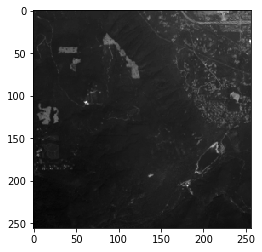

In [31]:
extWindow = rBndNP[cnPixN-(256//2):cnPixN+(256//2),cnPixE-(256//2):cnPixE+(256//2)]

#wanted to figure out how to overlay over the larger scene but it was 
#taking too long
plt.figure()
im2 = plt.imshow(extWindow,cmap='gray')


## Write a function to normalize the DN values
* Input values are UInt16 (unsigned, 16-bit integer) pixel DN values in a NumPy array (0-65535)
* Want float32 values over the range (0.0-1.0)
* Can use min and max, or the 2-98 percentiles (my preference)
* This should be pretty simple - don't overthink it

In [32]:
def Norm(Arr,upPerc,loPerc):
    Upper = np.percentile(Arr,upPerc)
    Lower = np.percentile(Arr,loPerc)
    Arr = np.divide(np.subtract(Arr,Lower),Upper-Lower)
    Arr[Arr > 1] = 1
    Arr[Arr < 0] = 0
    return Arr

WindowNorm = Norm(extWindow,98,2)

## Try running imshow on after normalizing the array with percentile stretch

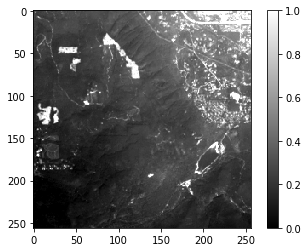

In [33]:
plt.figure()
plt.imshow(WindowNorm,cmap='gray')
plt.colorbar()

## Define the projected image extent to pass to matplotlib imshow
* See doc on `extent` here: https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html

In [34]:
#This is full image
extent = [rBnd.bounds.left, rBnd.bounds.right, rBnd.bounds.bottom, rBnd.bounds.top]
print(extent)

[473385.0, 706815.0, 5136885.0, 5373315.0]


## Rerun your original, full-image imshow command by passing this extent as an argument
* Note how the coordinates change

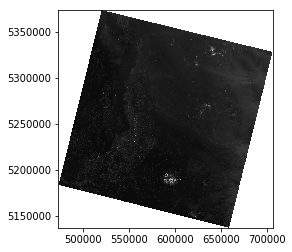

In [35]:
plt.figure()
plt.imshow(rBndNP_masked,cmap='gray',extent = extent)

## Define a subwindow for subsequent analysis
* Could do the remainder of the analysis with the full images, but faster with a small subset
* Use the `rasterio.windows.Window` functionality for this
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_off, row_off, width, height)`

In [36]:
import rasterio.windows
window = rasterio.windows.Window(3600, 5600, 1024, 1024)
window_bounds = rasterio.windows.bounds(window, rBnd.transform)
extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]

## Define a function to read in only this subwindow

In [37]:
def rio2ma(fn, b=1, window=None):
    a = None
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        a = src.read(b, window=window)
        a = a.astype('float32')
        a[a==0] = np.nan
        return a

# Panchromatic

In [38]:
p = rio2ma(p_fn, window=window)

In [39]:
p.shape

(2048, 2048)

# Display the Panchromatic band with matplotlib imshow
* https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html#matplotlib.axes.Axes.imshow
* Use the 'gray' colormap
* Provide the extent

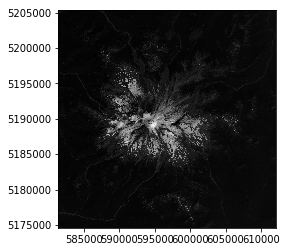

In [40]:
plt.figure()
plt.imshow(p,cmap='gray',extent = extent)

# RGB (red, gree, blue)
* Load the red, green and blue channels to arrays - make sure you use the window!
* Create a plot showing them separately
* Use numpy `dstack` to create a 3-band array

In [41]:
red = rio2ma(r_fn, window=window)
gree = rio2ma(g_fn, window=window)
blue = rio2ma(b_fn, window=window)

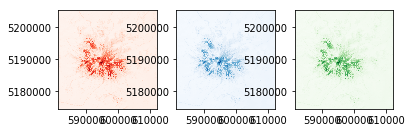

In [42]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(red,extent=extent,cmap='Reds')
plt.subplot(1,3,2)
plt.imshow(blue,extent=extent,cmap='Blues')
plt.subplot(1,3,3)
plt.imshow(gree,extent=extent,cmap='Greens')

In [43]:
rednorm = Norm(red,98,2)
bluenorm = Norm(blue,98,2)
greenorm = Norm(gree,98,2)

band3 = np.dstack((rednorm,greenorm,bluenorm))

## Create a plot of the RGB composite
* Pass the extent
* Add a dynamic scalebar with the matplotlib-scalebar functionality

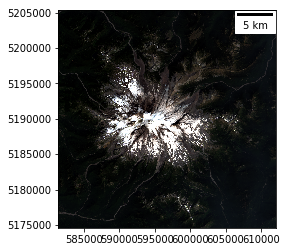

In [44]:
f, ax = plt.subplots()
ax.imshow(band3, extent=extent)
ax.add_artist(ScaleBar(1))

# CIR (color-infrared)
* Create a similar plot for color-infrared image
* Look up the band combination required

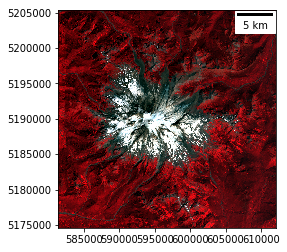

In [45]:
NIR = rio2ma(nir_fn, window=window)
nirnorm = Norm(NIR,98,2)
band3CIR = np.dstack((nirnorm,rednorm,greenorm))

f, ax = plt.subplots()
ax.imshow(band3CIR, extent=extent)
ax.add_artist(ScaleBar(1))

## Create a composite, interactive figure with linked PAN, RGB, and CIR
* Use the `plt.subplots()` with appropriate number of rows and columns
* Use the `sharex` and `sharey` options
* Set an appropriate figsize
* Pass the projected bounds to the imshow extent option
* Use gray colormap for the PAN
* Add a scalebar to the first plot using matplotlib-scalebar: https://pypi.org/project/matplotlib-scalebar/
    * This is already installed on the jupyterhub
    * Read the doc - this sentence "If the the axes image has already been calibrated by setting its extent, set dx to 1.0." is important
    * Do a sanity check based on the known image dimensions, pixel resolution, and displayed value
* Add appropriate titles to each subplot
* Use `plt.tight_layout()`

Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit

Text(0.5, 1.0, 'CIR Composite')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


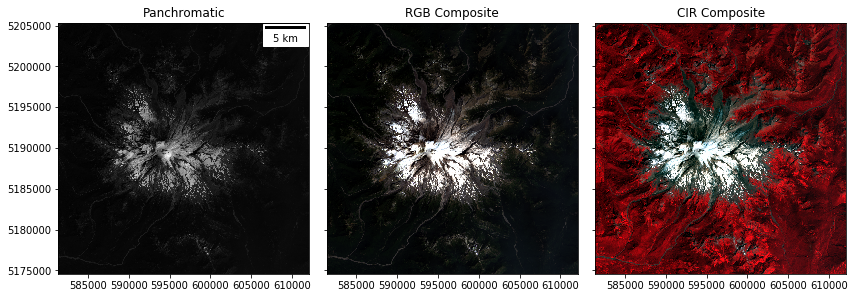

In [46]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,6),tight_layout=True)
ax1.imshow(p,cmap='gray',extent = extent)
ax1.add_artist(ScaleBar(1))
ax1.set_title('Panchromatic')
ax2.imshow(band3,extent=extent)
ax2.set_title('RGB Composite')
ax3.imshow(band3CIR,extent=extent)
ax3.set_title('CIR Composite')

## Analysis
* Zoom all the way in until you see individual pixels
    * Note the difference in resolution between the PAN and RGB/CIR images
* Note the changing values for (x,y) coordinates and the DN value(s) in the lower right corner of your plot
    * Should be 1 values for PAN, 3 values for RGB and CIR
    * All values are normalized from 0-1
* Experiment with some different interpolation methods for display: https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
    * At least try 'bilinear', 'bicubic'
    * Maybe create a separate figure showing a few different methods for a feature
    * Note how this affects your ability to resolve features in the images 


Text(0.5, 1.0, 'Bicubic')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


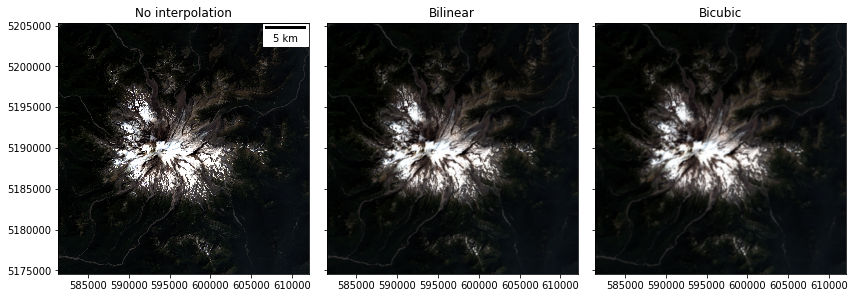

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,6),tight_layout=True)
ax1.imshow(band3,extent=extent)
ax1.add_artist(ScaleBar(1))
ax1.set_title('No interpolation')
ax2.imshow(band3,extent=extent,interpolation='bilinear')
ax2.set_title('Bilinear')
ax3.imshow(band3,extent=extent,interpolation='bicubic')
ax3.set_title('Bicubic')

# NDVI (normalized difference vegetation index)
* Create a new array to store NDVI this from the bands you've already loaded
* This should be a simple one-liner, basic raster band math
* Plot and inspect

https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


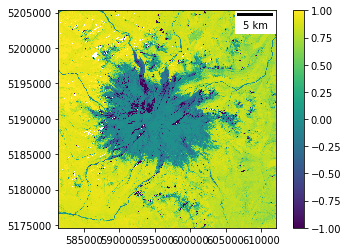

In [48]:
NDVI = np.divide((nirnorm-rednorm),(nirnorm+rednorm))

f, ax = plt.subplots()
cax = ax.imshow(NDVI, extent=extent)
ax.add_artist(ScaleBar(1))
f.colorbar(cax)

## NDSI (normalized difference snow index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


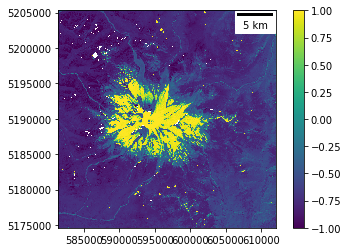

In [49]:
SWIR = rio2ma(swir_fn, window=window)
swirnorm = Norm(SWIR,98,2)

NDSI = np.divide((greenorm-swirnorm),(greenorm+swirnorm))

f, ax = plt.subplots()
cax = ax.imshow(NDSI, extent=extent)
ax.add_artist(ScaleBar(1))
f.colorbar(cax)

## Create a composite, interactive figure with linked RGB, CIR, NDVI and NDSI products

* Use the pan/zoom functionality of `%matplotlib widget` to explore the scene a bit
* Try to get a better sense of what the different indices are showing


Text(0.5, 1.0, 'NDSI')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


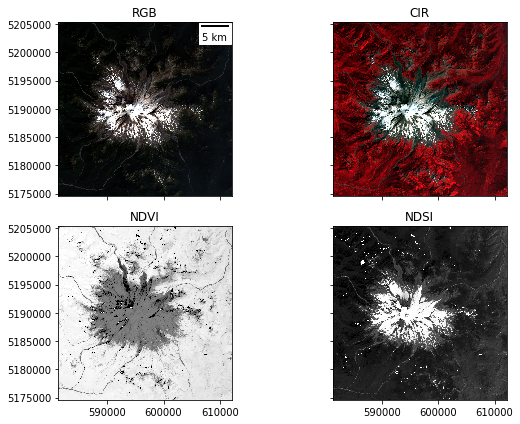

In [50]:
f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,6),tight_layout=True)
ax1.imshow(band3,extent=extent)
ax1.add_artist(ScaleBar(1))
ax1.set_title('RGB')
ax2.imshow(band3CIR,extent=extent)
ax2.set_title('CIR')
ax3.imshow(NDVI,extent=extent,cmap='gray')
ax3.set_title('NDVI')
ax4.imshow(NDSI,extent=extent,cmap='gray')
ax4.set_title('NDSI')